In [1]:
from keystone.model import Net
from keystone.keystone import calculate_keystone_array
from keystone.data_loading import process_data

from main import train
from types import SimpleNamespace

import seaborn as sns
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [3]:
training_params = SimpleNamespace(
        file_path = './data/DKI_data/Ptrain.csv',
        batch_size = 16,
        val_size = 0.1,
        lr = 0.05,
        epochs = 1000,
        verbosity = 100,
        layers = [100]
    )

In [4]:
loss, network = train(training_params)

Epoch: 0 	Training Loss: 1.47e-04 	Validation Loss: 3.87e-05
Epoch: 100 	Training Loss: 1.72e-06 	Validation Loss: 1.83e-06
Epoch: 200 	Training Loss: 1.24e-06 	Validation Loss: 1.34e-06
Epoch: 300 	Training Loss: 7.92e-07 	Validation Loss: 8.92e-07
Epoch: 400 	Training Loss: 5.83e-07 	Validation Loss: 6.99e-07
Epoch: 500 	Training Loss: 4.64e-07 	Validation Loss: 5.65e-07
Epoch: 600 	Training Loss: 3.66e-07 	Validation Loss: 4.70e-07
Epoch: 700 	Training Loss: 3.03e-07 	Validation Loss: 4.13e-07
Epoch: 800 	Training Loss: 2.47e-07 	Validation Loss: 3.60e-07
Epoch: 900 	Training Loss: 2.12e-07 	Validation Loss: 3.17e-07


In [5]:
losses = torch.load('simple_net_loss.pt')
losses.keys()

dict_keys(['train', 'val'])

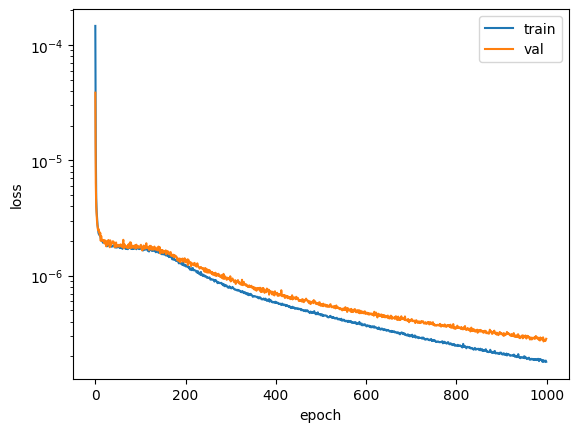

In [6]:
plt.semilogy(losses['train'], label='train')
plt.semilogy(losses['val'], label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [7]:
state_dict = torch.load('./simple_net.pt')
net = Net(100, 100, layers=[100])
net.load_state_dict(state_dict)

<All keys matched successfully>

In [8]:
X, Y = process_data('./data/DKI_data/Ptrain.csv')
K = calculate_keystone_array(X, Y, net)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:01<00:00, 296.73it/s]


<Axes: >

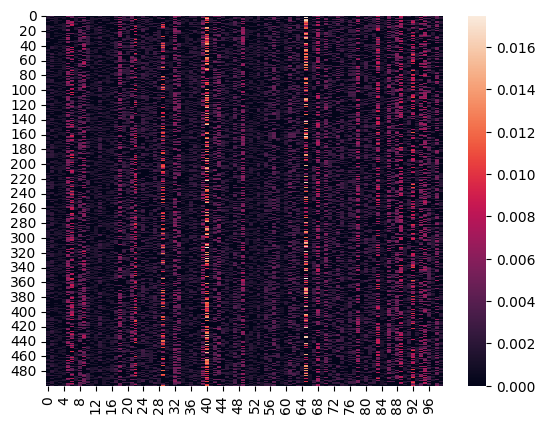

In [9]:
sns.heatmap(K)

In [10]:
indices = np.where(K.T != 0)
non_zero = np.array([(i+1, j+1, K.T[i,j]) for i, j in zip(indices[0], indices[1])])
dataframe = pd.DataFrame(non_zero, columns=['i', 'j', 'K[i,j]'])
my_keystones = dataframe["K[i,j]"].values

DKI_keystone = np.genfromtxt('./data/DKI_data/keystoness_species.csv', delimiter=',')[1:,:]
pred_keystones = DKI_keystone[:,0]
true_keystones = DKI_keystone[:,2]

In [11]:
# save as csv
np.savetxt('keystoness.csv', K, delimiter=',', header='i,j,K[i,j]')

In [12]:
import pandas as pd
dataframe = pd.DataFrame(non_zero, columns=['Species', 'Sample', 'Structural Keystoness'])
dataframe.tail(20)

,Species,Sample,Structural Keystoness
24980,100.0,459.0,0.001850
24981,100.0,461.0,0.001974
24982,100.0,462.0,0.001694
24983,100.0,463.0,0.002063
24984,100.0,467.0,0.002248
24985,100.0,468.0,0.001883
24986,100.0,470.0,0.002142
24987,100.0,471.0,0.002163
24988,100.0,473.0,0.001657
24989,100.0,474.0,0.001880


Text(0.005, 0.02, '${\\rho}$ = 0.9509')

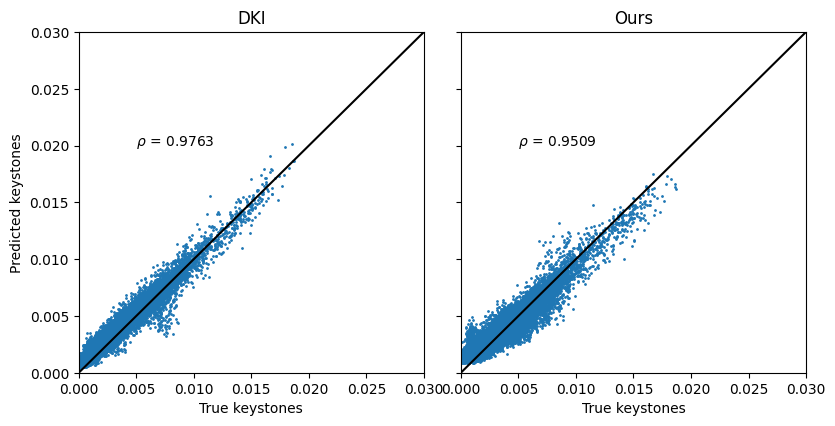

In [13]:

fig, (ax1, ax2) = plt.subplots(figsize=(8,4), ncols=2, sharey=True)
fig.tight_layout()
ax1.scatter(true_keystones, pred_keystones, s=1)
ax1.plot([0,0.03], [0,0.03], 'k-')
ax1.set_xlim(0,0.03)
ax1.set_ylim(0,0.03)
ax1.set_xlabel('True keystones')
ax1.set_ylabel('Predicted keystones')
ax1.set_title('DKI')

ax2.scatter(true_keystones, my_keystones, s=1)
ax2.plot([0,0.03], [0,0.03], 'k-')
ax2.set_xlim(0,0.03)
ax2.set_ylim(0,0.03)
ax2.set_xlabel('True keystones')
ax2.set_title('Ours')

# correlation
from scipy.stats import pearsonr
ax1.text(0.005,0.02,f"${{\\rho}}$ = {pearsonr(true_keystones, pred_keystones)[0]:.4f}")
ax2.text(0.005,0.02,f"${{\\rho}}$ = {pearsonr(true_keystones, my_keystones)[0]:.4f}")


# North American Data

In [21]:
training_params = SimpleNamespace(
        file_path = './data/Ptrain.csv',
        batch_size = 16,
        val_size = 0.1,
        lr = 0.001,
        epochs = 1000,
        verbosity = 100,
        layers = [1324, 1324]
    )

In [22]:
loss, model = train(training_params)

Epoch: 0 	Training Loss: 8.31e-05 	Validation Loss: 7.63e-05
Epoch: 100 	Training Loss: 3.79e-05 	Validation Loss: 4.03e-05
Epoch: 200 	Training Loss: 1.99e-05 	Validation Loss: 2.46e-05
Epoch: 300 	Training Loss: 1.54e-05 	Validation Loss: 2.16e-05
Epoch: 400 	Training Loss: 1.30e-05 	Validation Loss: 2.02e-05
Epoch: 500 	Training Loss: 1.12e-05 	Validation Loss: 2.04e-05
Epoch: 600 	Training Loss: 1.01e-05 	Validation Loss: 2.10e-05
Epoch: 700 	Training Loss: 9.26e-06 	Validation Loss: 2.08e-05
Epoch: 800 	Training Loss: 8.63e-06 	Validation Loss: 2.09e-05
Epoch: 900 	Training Loss: 8.00e-06 	Validation Loss: 2.05e-05


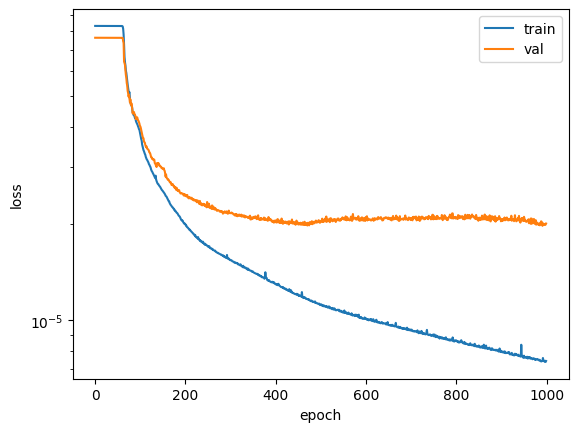

In [23]:
plt.semilogy(loss['train'], label='train')
plt.semilogy(loss['val'], label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [24]:
state_dict = torch.load('./simple_net.pt')
net = Net(1324, 1324, layers=[1324, 1324])

net.load_state_dict(state_dict)

<All keys matched successfully>

In [25]:
X, Y = process_data('./data/Ptrain.csv')
K = calculate_keystone_array(X, Y, net)

100%|██████████| 2971/2971 [09:28<00:00,  5.22it/s]


<Axes: >

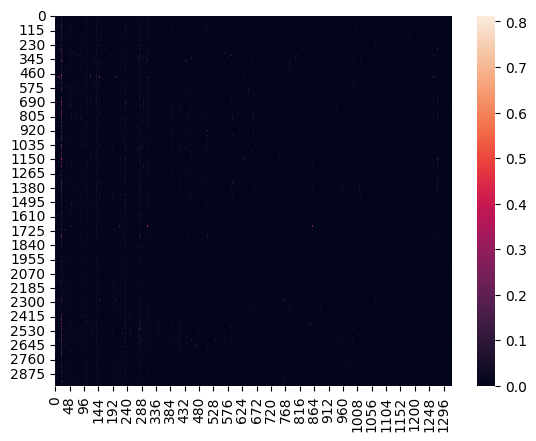

In [26]:
sns.heatmap(K)

In [12]:
indices = np.where(K.T != 0)
non_zero = np.array([(i+1, j+1, K.T[i,j]) for i, j in zip(indices[0], indices[1])])
dataframe = pd.DataFrame(non_zero, columns=['i', 'j', 'K[i,j]'])
my_keystones = dataframe["K[i,j]"].values

In [16]:
A = my_keystones.reshape(-1, )

ValueError: cannot reshape array of size 435420 into shape (1324,newaxis)

# Implementing the Neural ODE from cNode
### (or whatever it's called)

In [1]:
import torch
import torch.nn as nn
from torchdiffeq import odeint

In [2]:
def get_batch(ztrn,ptrn,mb_size):
    s = torch.from_numpy(np.random.choice(np.arange(ptrn.size(dim=0), dtype=np.int64), mb_size, replace=False))
    batch_p = ztrn[s,:]
    batch_q = ptrn[s,:]
    batch_t = torch.tensor(np.linspace(0, 1, 100, endpoint=False), dtype=torch.float32)
    return batch_p.to(device), batch_q.to(device),batch_t.to(device)


def loss_bc(p_i, q_i):
    return torch.sum(torch.abs(p_i-q_i))/torch.sum(torch.abs(p_i+q_i))


def process_data(P):
    Z = P.copy()
    Z[Z>0] = 1
    P = P/P.sum(axis=0)[np.newaxis,:]
    Z = Z/Z.sum(axis=0)[np.newaxis,:]
    
    P = P.astype(np.float32)
    Z = Z.astype(np.float32)

    P = torch.from_numpy(P.T)
    Z = torch.from_numpy(Z.T)
    return P,Z


class ODEFunc(torch.nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.fcc1 = torch.nn.Linear(N, N)
        self.fcc2 = torch.nn.Linear(N, N)

    def forward(self, t, y):
        out = self.fcc1(y)
        out = nn.ReLU()(out)
        out = self.fcc2(out)
        f = torch.matmul(torch.matmul(torch.ones(y.size(dim=1),1),y),torch.transpose(out,0,1))
        return torch.mul(y,out-torch.transpose(f,0,1))

In [7]:
from tqdm import tqdm
import copy
import numpy as np

In [33]:
def train_reptile(max_epochs,mb,LR,ztrn,ptrn,zval,pval):
    loss_train = []
    loss_val = []
    
    func = ODEFunc().to(device)
    optimizer = torch.optim.Adam(func.parameters(), lr=LR)

    Loss_opt = 1
    loop_obj = tqdm(range(max_epochs))
    for e in loop_obj:
        
        optimizer.zero_grad()
        batch_p, batch_q, batch_t = get_batch(ztrn,ptrn,mb)
        
        for i in range(mb):
            p_pred = odeint(func,batch_p[i].unsqueeze(dim=0),batch_t).to(device)
            p_pred = torch.reshape(p_pred[-1,:,:],(1,N))
            if i==0:
                loss = loss_bc(p_pred.unsqueeze(dim=0),batch_q[i].unsqueeze(dim=0))
            else:
                loss = loss + loss_bc(p_pred.unsqueeze(dim=0),batch_q[i].unsqueeze(dim=0))
                
        loss_train.append(loss.item()/mb)

        dtype = torch.float32

        # validation set
        for i in range(zval.size(dim=0)):
            p_pred = odeint(func,zval[i].unsqueeze(dim=0),batch_t).to(device)
            p_pred = torch.reshape(p_pred[-1,:,:],(1,N))
            if i==0:
                l_val = loss_bc(p_pred.unsqueeze(dim=0),pval[i].unsqueeze(dim=0))
            else:
                l_val = l_val + loss_bc(p_pred.unsqueeze(dim=0),pval[i].unsqueeze(dim=0))
        loss_val.append(l_val.item()/zval.size(dim=0))
        if l_val.item()/zval.size(dim=0)<=Loss_opt:
            Loss_opt = loss_val[-1]
            best_model = copy.deepcopy(func)
        #print('epoch = ',e, 'loss = ', l_val.item()/mb)

        # update the neural network
        func.zero_grad()
        loss.backward()
        optimizer.step()

        loop_obj.set_postfix_str(f"epoch: {e+1}, loss: {loss_val[-1]:.4f}")
        

    return best_model, loss_train, loss_val

In [34]:
# hyperparameters
max_epochs = 100
device = 'cpu'
batch_time = 100
t = torch.arange(0.0, batch_time, 0.01)

# load the dataset
filepath_train = './data/DKI_data/Ptrain.csv'
filepath_test = './data/DKI_data/Ptest.csv' # Replace "Ptest.csv" with "Ztest.csv" for real dataset.



In [35]:
P = np.loadtxt(filepath_train,delimiter=',')
number_of_cols = P.shape[1]
random_indices = np.random.choice(number_of_cols, size=int(0.2*number_of_cols), replace=False)
P_val = P[:,random_indices]
P_train =  P[:,np.setdiff1d(range(0,number_of_cols),random_indices)]
ptrn,ztrn = process_data(P_train)
pval,zval = process_data(P_val)
pall,zall = process_data(P)

M, N = ptrn.shape

In [36]:
LR = 0.01
mb = 20

loss_train,qtst,qtrn = train_reptile(max_epochs,mb,LR,ztrn,ptrn,zval,pval)

 55%|█████▌    | 55/100 [01:38<01:29,  2.00s/it, epoch: 55, loss: 0.0332]

Text(0, 0.5, 'Loss')

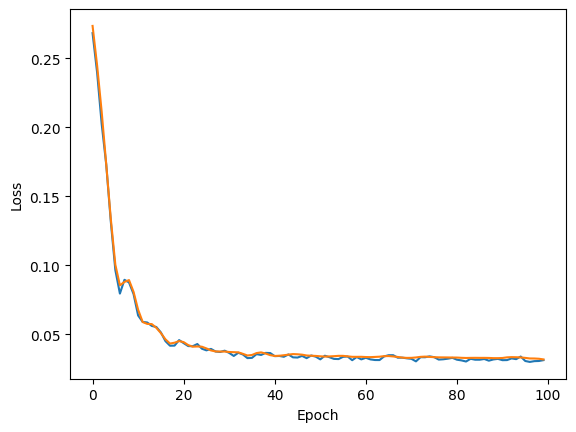

In [114]:
import matplotlib.pyplot as plt

plt.plot(qtst)
plt.plot(qtrn)
plt.xlabel('Epoch')
plt.ylabel('Loss')


In [10]:
batch_t

NameError: name 'batch_t' is not defined

In [21]:
SOLVERS = {
    'dopri8': 1,
    'dopri5': 2,
}

In [22]:
SOLVERS[None]

KeyError: None